In [3]:
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.dates import date2num, DateFormatter, WeekdayLocator, DayLocator, MONDAY
import seaborn as sns

import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

from scipy import stats
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

import datetime
from datetime import date, timedelta

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
#Get the data
data = pd.read_csv("data/M2SL.csv")

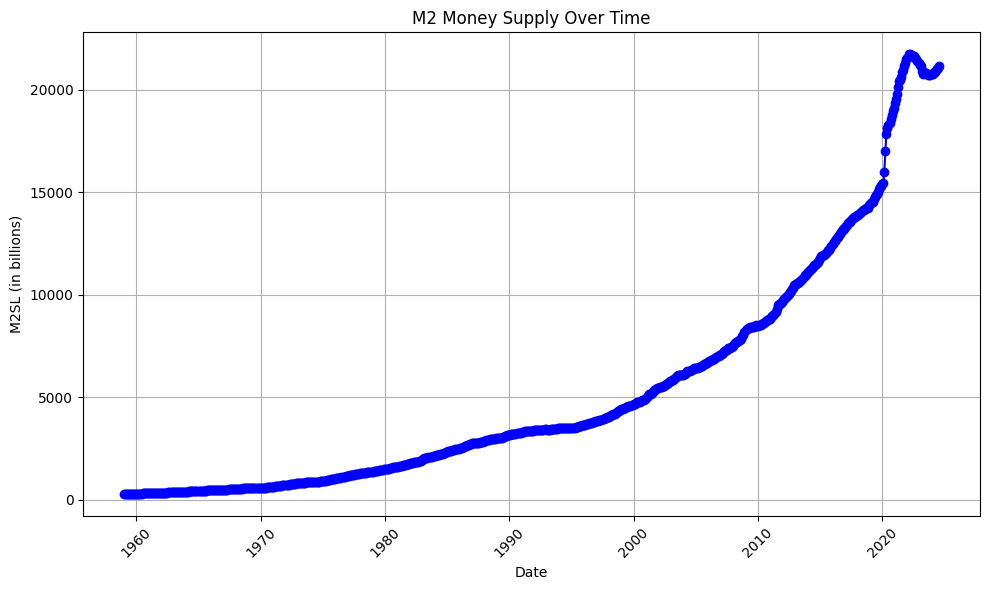

In [6]:
data['DATE'] = pd.to_datetime(data['DATE'])

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['DATE'], data['M2SL'], linestyle='-', color='b')
plt.title('M2 Money Supply Over Time')
plt.xlabel('Date')
plt.ylabel('M2SL (in billions)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()